In [1]:
import numpy as np
import cv2 as cv
import csv
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

## Decoding RLEs into masks for training

In [2]:
def decode_rle_to_mask(rle, height, width, viz=False):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1))
    if viz:
        color = np.random.rand(1)
    else:
        color = 1
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1])] = color

    return mask.reshape(height, width)

### Training Pipeline

In [3]:
#read train csv file in a dataframe
train_df = pd.read_csv("/kaggle/input/Multiclass-segmentation/train.csv")
# array containing names of images
train_img_names = train_df["ImageName"].unique()
#choose width and hight for resizing
img_shape=(256,256)
width=256
height=256
batch_size=8
#colors for better visualization of labels
colors={0:(0,0,0),
       1:(0,255,255),
        2:(255,0,0),
        3:(0,255,0),
        4:(0,0,255),
        -1:(0,0,0)
       }


In [4]:
def read_img_label(img_name):
    imagePath = os.path.sep.join(['/kaggle/input/Multiclass-segmentation/TrainImages', img_name+str('.jpg')])
    #reading rgb image from path
    img = cv.imread(imagePath)
    #resizing image so all images can have the same size
    img = cv.resize(img,img_shape)
    #get masks of the image from train csv file
    masks=train_df.loc[train_df.ImageName==img_name]
    #loobing over masks to create one channel label img
    #mask------> [name,width,height,class_num,encodings]
    combined_masks=0
    for _, mask in masks.iterrows():
        combined_masks=combined_masks+decode_rle_to_mask(mask[4],int(mask[1]), int(mask[2]))*int(mask[3])
    #resizing label to match new image size then taking the integer value  
    combined_masks=cv.resize(combined_masks,img_shape).astype('uint8')   
    #return both image and label
    return img,combined_masks
    

[0 1 2 3]
[0 1 2]
[0 1 2 3]
[0 1 2 3 4]


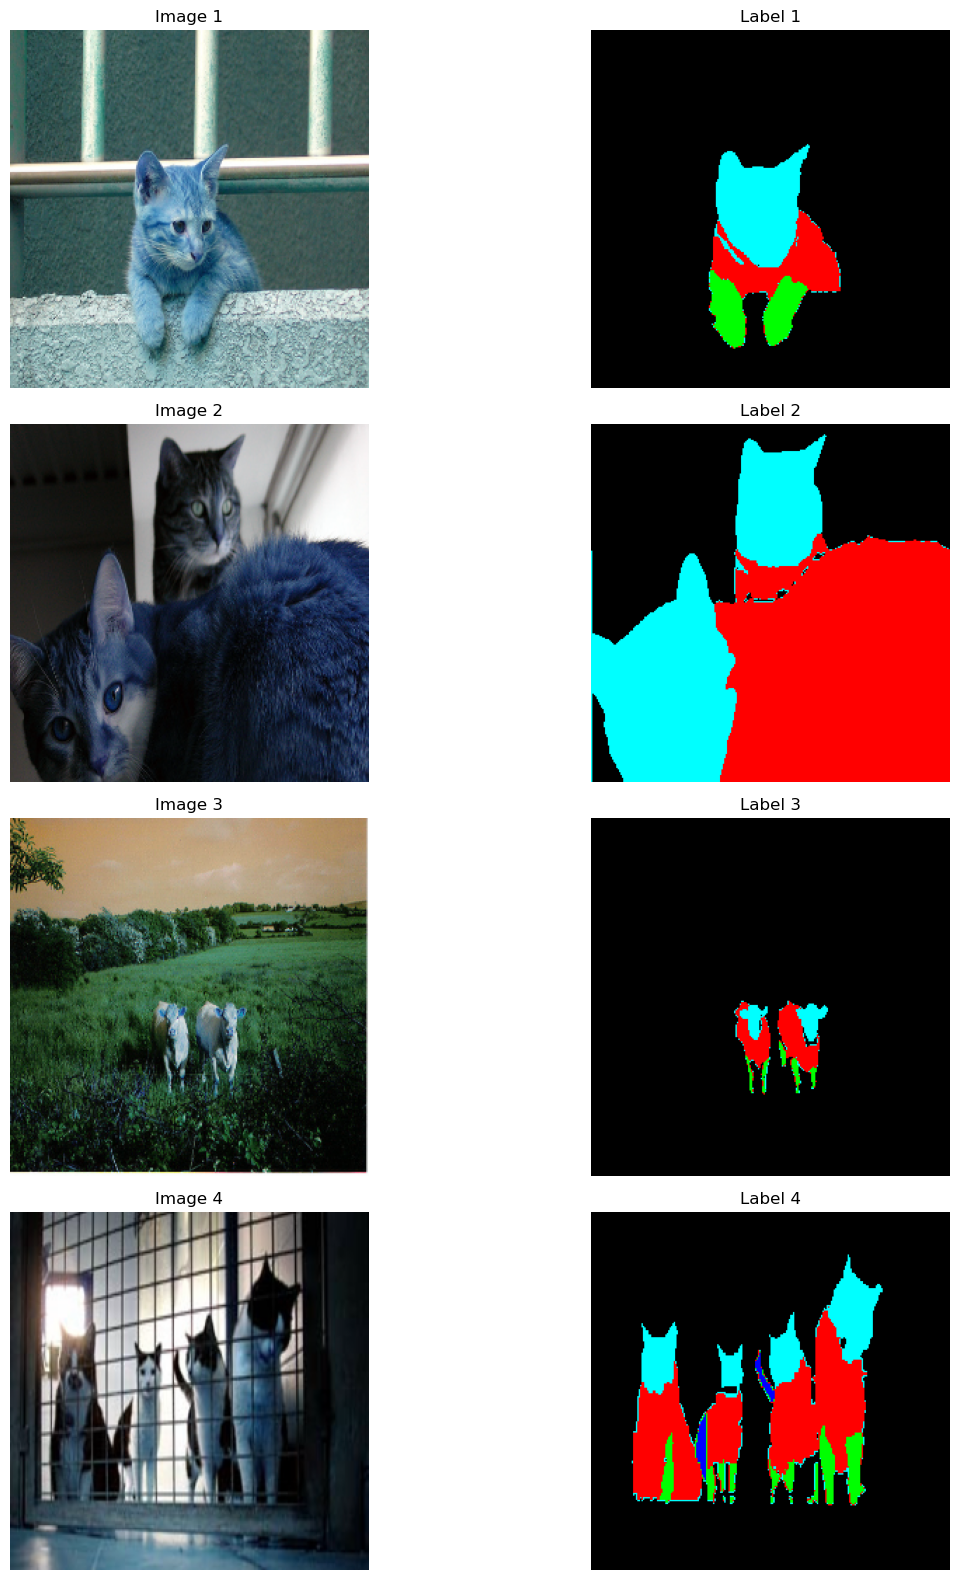

In [5]:
#testing the load function and encoding
plt.figure(figsize=[15, 20])
for i in range(4):    
    img ,enc= read_img_label(train_img_names[i])
    print(np.unique(enc))
    coloredlabel = np.zeros([enc.shape[0], enc.shape[1], 3])
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            coloredlabel[row, col, :] = colors[enc[row, col]]
    coloredlabel = coloredlabel.astype('uint8')                        
    plt.subplot(4, 2, i*2 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    plt.subplot(4, 2, i*2 + 2)
    plt.imshow(coloredlabel)
    plt.axis('off')
    plt.gca().set_title('Label {}'.format(str(i+1)))
plt.subplots_adjust(wspace=0, hspace=0.1)

In [6]:
tf.math.argmax(tf.one_hot(enc,5),axis=-1)

<tf.Tensor: shape=(256, 256), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

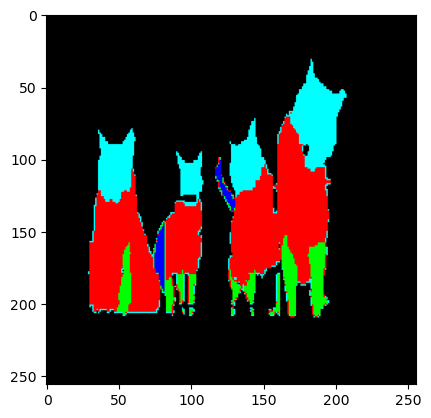

In [7]:
for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            coloredlabel[row, col, :] = colors[enc[row, col]]
plt.imshow(coloredlabel)


In [8]:
def DataGenerator(names, batch_size=10, classes=5):
    while True:
        for i in range(0, len(names), batch_size):
            batch_names = names[i : i+batch_size]
            imgs=[]
            labels=[]
            for name in batch_names:
                image, label = read_img_label(name)
                imgs.append(image)
                labels.append(label)
            yield np.array(imgs), np.array(labels)

#train_gen = DataGenerator(train_names, batch_size=10)
#val_gen = DataGenerator(val_names, batch_size=10)


In [9]:
#spliting train data for validation
train_names, val_names = train_test_split(train_img_names, test_size=0.2, random_state=42)
#create tf datasets

X_train=[]
Y_train=[]
for name in train_names:
    image, label = read_img_label(name)
    X_train.append(image)
    Y_train.append(tf.one_hot(label,5))
X_val=[]
Y_val=[]
for name in val_names:
    image, label = read_img_label(name)
    X_val.append(image)
    Y_val.append(tf.one_hot(label,5))
    
train_ds=tf.data.Dataset.from_tensor_slices((X_train,Y_train)).batch(batch_size=batch_size)
val_ds=tf.data.Dataset.from_tensor_slices((X_val,Y_val)).batch(batch_size=batch_size)
del X_train
del Y_train
del X_val
del Y_val

2023-02-18 00:50:27.084259: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2732064768 exceeds 10% of free system memory.
2023-02-18 00:53:09.192011: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2276720640 exceeds 10% of free system memory.


In [10]:
!pip install git+https://github.com/qubvel/segmentation_models


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-lx78qbo0
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-lx78qbo0
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=93f71eebf85eb37a22e6bcbabb162f63001d2e5283247ee01d2d421e0a9dc57c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3n5zrouh/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [11]:
from segmentation_models import Unet
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score

BACKBONE = 'efficientnetb0'
# define model
model = Unet(BACKBONE, encoder_weights='imagenet',encoder_freeze=True, input_shape=(width, height, 3),activation='softmax', classes=5)
model.compile('adam', loss=DiceLoss(class_weights=[1.1,1,1,1,1]), metrics=[iou_score])


Segmentation Models: using `keras` framework.
16804768/16804768 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 32  128         ['stem_conv[0][0]']              
                                )                                                             

In [13]:
MODEL_CHECKPOINT_FILEPATH = '/kaggle/working/unet.ckpt'
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_iou_score',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', 
                               patience = 5,
                               restore_best_weights = True, 
                               min_delta = 0.001,
                               mode='max',
                               verbose=2,
                               baseline=None)
    
callbacks = [model_checkpoint , early_stopping]

In [14]:
# fit model
history = model.fit(train_ds,
                    epochs = 50,
                    validation_data = val_ds,callbacks = callbacks)


2023-02-18 00:54:11.872767: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2276720640 exceeds 10% of free system memory.


Epoch 1/50
218/218 [==============================] - ETA: 0s - loss: 0.4925 - iou_score: 0.3866
Epoch 1: val_iou_score improved from -inf to 0.47464, saving model to /kaggle/working/unet.ckpt
218/218 [==============================] - 61s 187ms/step - loss: 0.4925 - iou_score: 0.3866 - val_loss: 0.4070 - val_iou_score: 0.4746
Epoch 2/50
217/218 [============================>.] - ETA: 0s - loss: 0.3888 - iou_score: 0.4861
Epoch 2: val_iou_score improved from 0.47464 to 0.51351, saving model to /kaggle/working/unet.ckpt
218/218 [==============================] - 35s 160ms/step - loss: 0.3889 - iou_score: 0.4856 - val_loss: 0.3673 - val_iou_score: 0.5135
Epoch 3/50
217/218 [============================>.] - ETA: 0s - loss: 0.3528 - iou_score: 0.5193
Epoch 3: val_iou_score improved from 0.51351 to 0.51860, saving model to /kaggle/working/unet.ckpt
218/218 [==============================] - 35s 160ms/step - loss: 0.3528 - iou_score: 0.5191 - val_loss: 0.3549 - val_iou_score: 0.5186
Epoch 4

In [15]:
del train_ds

In [16]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH) # load the best model weights

val_loss,val_IoU = model.evaluate(val_ds) # re-evaluate on the validation data

print('The model had an IoU of '+ str(format(round(100*val_IoU, 2))))

55/55 [==============================] - 2s 44ms/step - loss: 0.3047 - iou_score: 0.5711
The model had an IoU of 57.11


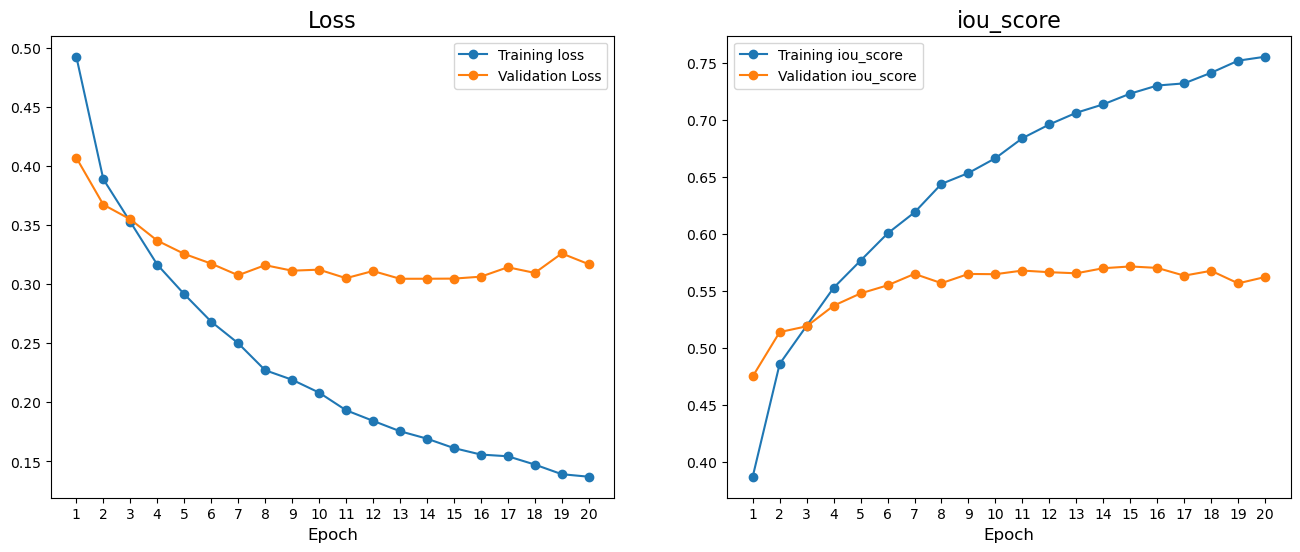

In [17]:
EPOCHS = len(history.history['loss'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, EPOCHS + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, EPOCHS + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, EPOCHS + 1), history.history['iou_score'], marker='o', label='Training iou_score')
ax2.plot(range(1, EPOCHS + 1), history.history['val_iou_score'], marker='o', label='Validation iou_score')
ax2.legend()
ax2.set_xticks(range(1, EPOCHS + 1))
ax2.set_title('iou_score', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

(8, 256, 256, 3)
(8, 256, 256, 5)
1/1 [==============================] - 2s 2s/step


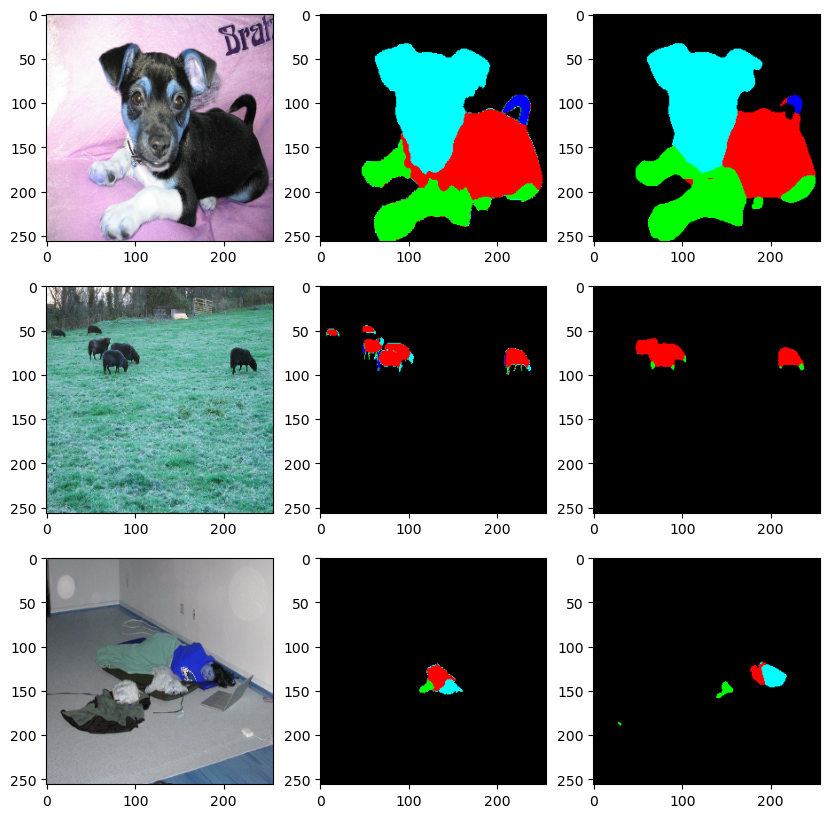

In [18]:
num = 3
for img, label in val_ds.take(1):
    print(img.shape)
    print(label.shape)

    pred_label = model.predict(img)
    pred_label = tf.argmax(pred_label, axis=-1).numpy()
    label = tf.argmax(label, axis=-1).numpy()

    tmp = np.zeros([batch_size,pred_label.shape[1], pred_label.shape[2], 3])
    tmp2 = np.zeros([batch_size,pred_label.shape[1], pred_label.shape[2], 3])
    for i in range(3):
        for row in range(pred_label.shape[1]):
            for col in range(pred_label.shape[2]):
                tmp[i,row, col, :] = colors[pred_label[i,row, col]]
                tmp2[i,row, col] = colors[label[i,row, col]]
                tmp = tmp.astype('uint8')
                tmp2 = tmp2.astype('uint8')
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(tmp2[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(tmp[i]))


(10, 256, 256, 3)
1/1 [==============================] - 2s 2s/step


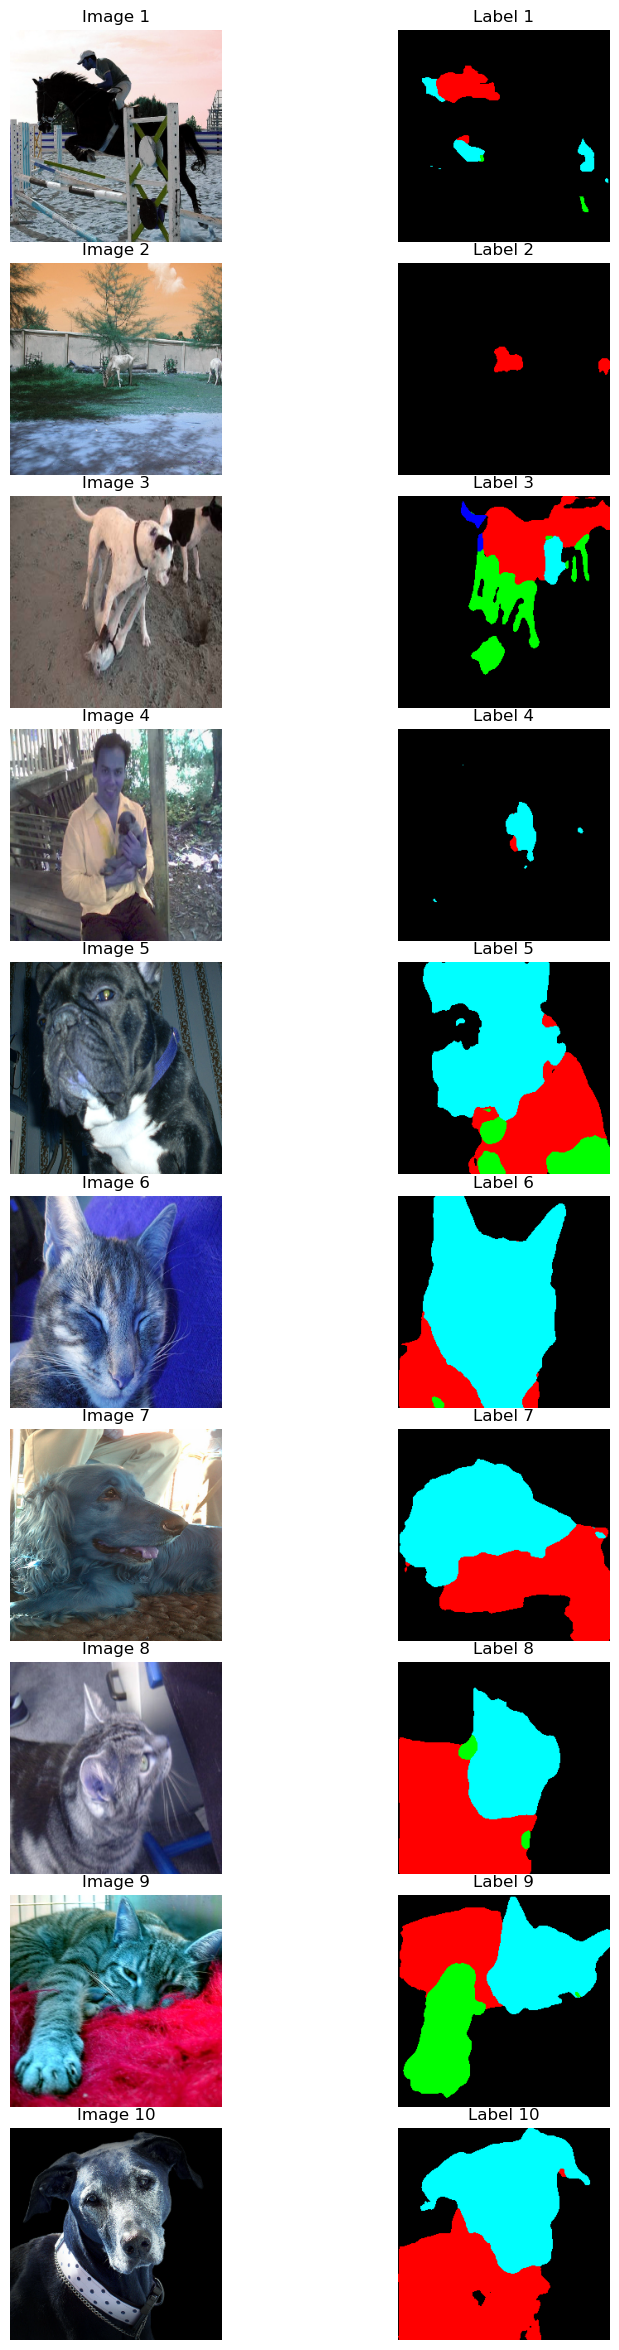

In [19]:
test_df = pd.read_csv("/kaggle/input/Multiclass-segmentation/test.csv")

test_img_names = test_df["ImageName"].unique()[:10]
test_batch=[]
for name in test_img_names:
    imagePath = os.path.sep.join(['/kaggle/input/Multiclass-segmentation/TestImages', name+str('.jpg')])
    #reading rgb image from path
    img = cv.imread(imagePath)
    #resizing image so all images can have the same size
    img = cv.resize(img,img_shape)
    test_batch.append(img)
print(np.array(test_batch).shape)
pred_label = model.predict(np.array(test_batch))


plt.figure(figsize=[10, 30])
for i in range(10):    
    enc=pred_label[i]
    enc=tf.math.argmax(enc,axis=-1).numpy()
    img=test_batch[i]
    coloredlabel = np.zeros([enc.shape[0], enc.shape[1], 3])
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            coloredlabel[row, col, :] = colors[enc[row, col]]
    coloredlabel = coloredlabel.astype('uint8')                        
    plt.subplot(10, 2, i*2 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    plt.subplot(10, 2, i*2 + 2)
    plt.imshow(coloredlabel)
    plt.axis('off')
    plt.gca().set_title('Label {}'.format(str(i+1)))
plt.subplots_adjust(wspace=0, hspace=0.1)

    

### Encoding masks into RLE for submission

In [20]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [21]:
masks=tf.one_hot(enc,5).numpy()

In [22]:
# IMPORTANT || Convert mask to grayscale
#mask1 = mask1[:,:,0] # or using other methods depending on mask
#mask1.shape


In [23]:
decoded=masks[:,:,0]
encodes = encode_mask_to_rle(decoded)
decodedagain=decode_rle_to_mask(encodes,256,256)


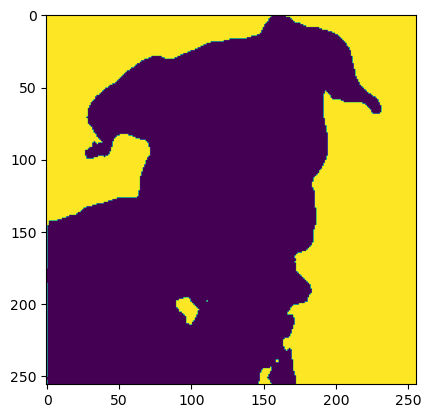

In [24]:
plt.imshow(decoded)


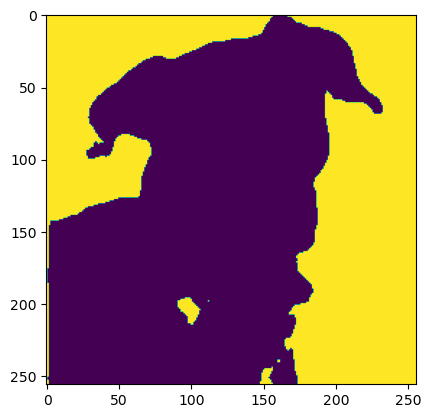

In [25]:
plt.imshow(decodedagain)

In [26]:
# for submission
test_df = pd.read_csv("/kaggle/input/Multiclass-segmentation/test.csv")

test_img_names = test_df["ImageName"].unique()
test_imgs=[]
for name in test_img_names:
    if len(name)<2:
        name='0'+name
    imagePath = os.path.sep.join(['/kaggle/input/Multiclass-segmentation/TestImages', name+str('.jpg')])
    #reading rgb image from path
    img = cv.imread(imagePath)
    #resizing image so all images can have the same size
    img = cv.resize(img,img_shape)
    test_imgs.append(img)
print(np.array(test_imgs).shape)
pred_label = model.predict(np.array(test_imgs))

(982, 256, 256, 3)
31/31 [==============================] - 8s 199ms/step


2023-02-18 01:08:20.154133: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1287127040 exceeds 10% of free system memory.


In [27]:
data=[]
for pred , name in zip(pred_label,test_img_names):
    originalwidth=test_df.loc[test_df['ImageName']==name]['ImageWidth'].values[0]
    originalheight=test_df.loc[test_df['ImageName']==name]['ImageHeight'].values[0]
    for i in range(5) :
        row=[0,0]
        mask=pred[:,:,i]
        row[0]=name
        mask=cv.resize(mask,(originalheight,originalwidth)).astype('int8')
        row[1]=encode_mask_to_rle(mask)
        if(row[1]!=''):
            data.append(row)
            

    

In [28]:
submissin_df=pd.DataFrame(data,columns=['ImageName','Encoding'])
submissin_df.to_csv('/kaggle/working/efficientnetb0_unet_submission.csv',index=False)


In [29]:
#Inference time
all_test=np.array(test_imgs)
test=model.predict(all_test)

31/31 [==============================] - 4s 143ms/step


2023-02-18 01:08:36.715919: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1287127040 exceeds 10% of free system memory.


In [30]:
one_test=np.array(test_imgs)[0].reshape(1,np.shape(test_imgs[0])[0],np.shape(test_imgs[0])[1],np.shape(test_imgs[0])[2])
test_2=model.predict(one_test)

1/1 [==============================] - 0s 30ms/step


In [31]:
np.shape(test_imgs[0])[0]

256